In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import polars as pl
from pathlib import Path
import data_visualization as dv
from time import time
import copy
import importlib
import dill 
import GTO
import dyad_gt_params as param
import constants as const
import plot_functions as pf
import model_functions as mf

wheel = dv.ColorWheel()

# Notebook Outline
## 1. Functions
  - create_single_trial_df: Puts each model trial for perturbations and probes into separate dataframes for plotting

## 2. Parameter Setup
  - Sets up the necessary parameters to run the model

# Functions

In [13]:
def create_single_trial_df(trial, model, state_mapping, condition, p1_target, p2_target, experiment_trial_number):
    df = pl.DataFrame()
    df = df.with_columns(
        timepoint = model.state_timesteps,
        condition = np.array([condition]*len(model.state_timesteps)),
        p1_target = np.array([p1_target]*len(model.state_timesteps)),
        p2_target = np.array([p2_target]*len(model.state_timesteps)),
        trial = np.array([trial]*len(model.state_timesteps)),
        experiment_trial_number = np.array([experiment_trial_number]*len(model.state_timesteps)),
        jump_type = np.array([model.perturbation_states[0]]*len(model.state_timesteps)),
        jump_time = np.array([model.jump_time]*len(model.state_timesteps)),
        jump_back_time = np.array([model.jump_back_time]*len(model.state_timesteps)),
        alpha = np.array([model.alpha]*len(model.state_timesteps),dtype=float),
        partner_knowledge = np.array([model.partner_knowledge]*len(model.state_timesteps)),
        p1_applied_force = np.append(np.array(model.applied_force1), np.nan),
        p2_applied_force = np.append(np.array(model.applied_force2), np.nan),
        u1x = np.append(model.u1[:,0],np.nan),
        u1y = np.append(model.u1[:,1],np.nan),
        u2x = np.append(model.u2[:,0],np.nan),
        u2y = np.append(model.u2[:,1],np.nan),
    )
    for key, val in state_mapping.items():
        df = df.with_columns(pl.Series(key, model.x[:,val]))
    return df

# Parameter Setup

In [14]:
HIT_TIME = 0.8
h=0.01

Q1 = mf.generate_Q(
    weight_dict=param.Q1_WEIGHTS, 
    state_mapping=param.state_mapping, 
    cross_terms=[["ccx","ctx"], ["ccy","cty"], 
                 ["rhy","lhy"]], 
    QVAL=param.QVAL
)
Q2 = mf.generate_Q(
    weight_dict=param.Q2_WEIGHTS, 
    state_mapping=param.state_mapping, 
    cross_terms=[["ccx","ctx"], ["ccy","cty"],
                    ["rhy","lhy"]], 
    QVAL = param.QVAL,
)

# Lists for experimental conditions where a narrow relevant target is QVAL and wide irrelevant target is IRREL_QVAL
Q1_xvals = [
    param.IRREL_QVAL, #  Both irrelevant
    param.QVAL, # P1 Relevant
    param.IRREL_QVAL, # P2 Relevant
    param.QVAL, # Both Relevant
]
Q2_xvals = [
    param.IRREL_QVAL, #  Both irrelevant
    param.IRREL_QVAL, # P1 Relevant
    param.QVAL, # P2 Relevant
    param.QVAL, # Both Relevant
]

# Self Energetic cost matrices
R11 = np.eye(param.B1.shape[1])*param.RVAL # Square Enery cost matrix with dimensions according to the columns of B
R22 = np.eye(param.B2.shape[1])*param.RVAL # Square Enery cost matrix with dimensions according to the columns of B

# Defines the models 
# (No Partner Representation/Self Cost, Partner Representation/Self Cost, Partner Representation/Equal Joint Cost, Partner Representation/Weighted Joint Cost)
partner_knowledge = [False, True, True, True]
help_percentages = [0.0, 0.0, 1.0, 0.5]

# Select perturbation type
jump_type = "ccx" # Can change this to "ccx" (center cursor x-pos) or "ctx" (target x-pos)
if jump_type == "ctx":
    perturbation = -param.perturbation_distance
else:
    perturbation = param.perturbation_distance
    
state_mapping = param.state_mapping

# Run Models

model 1


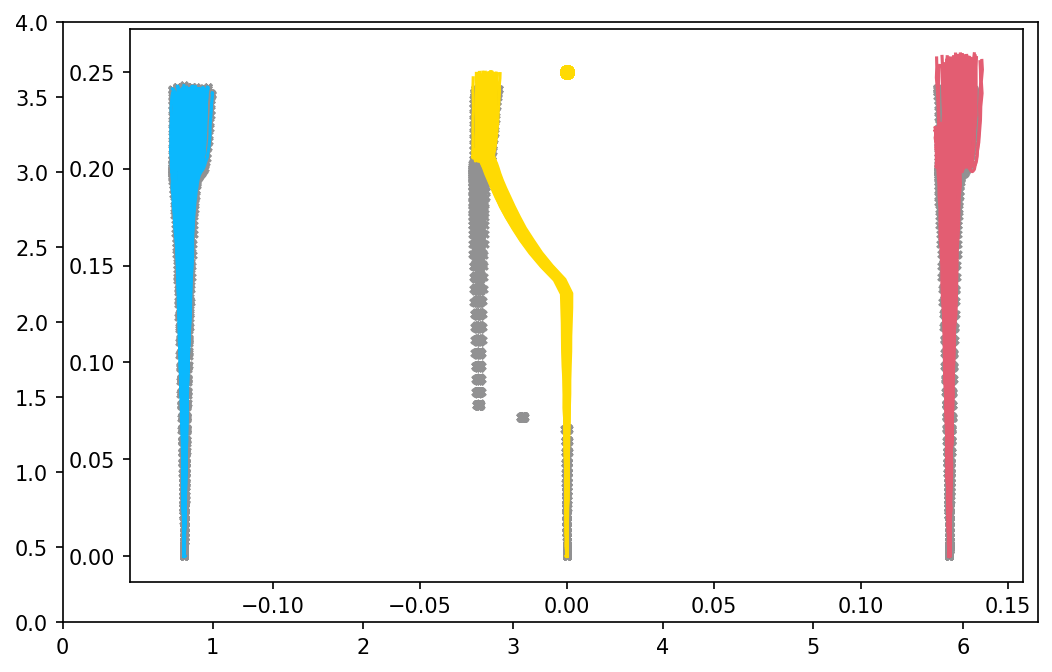

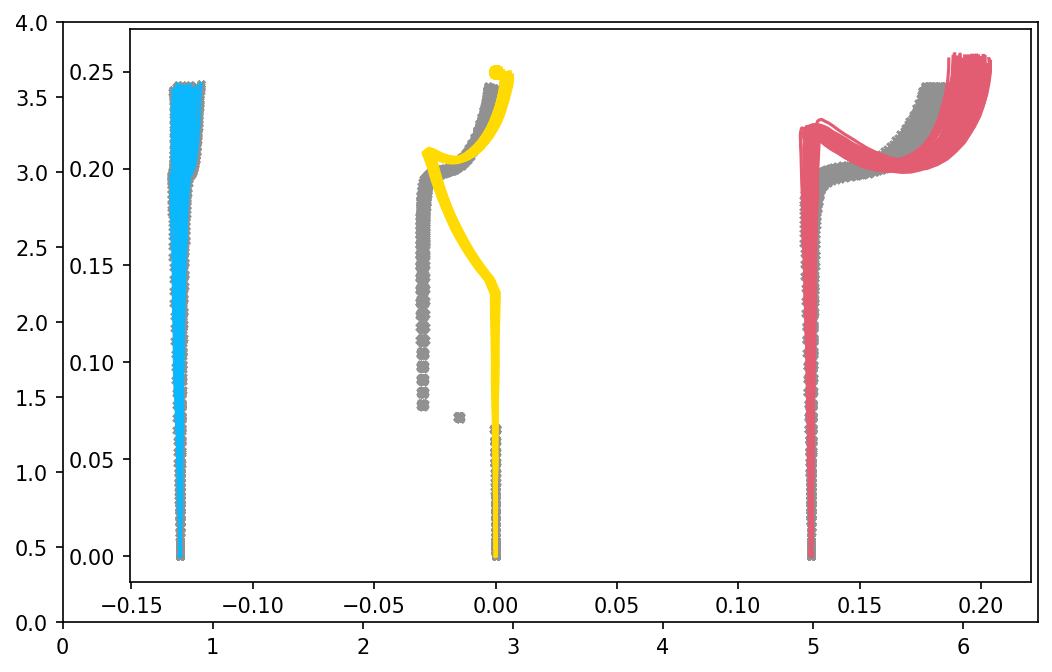

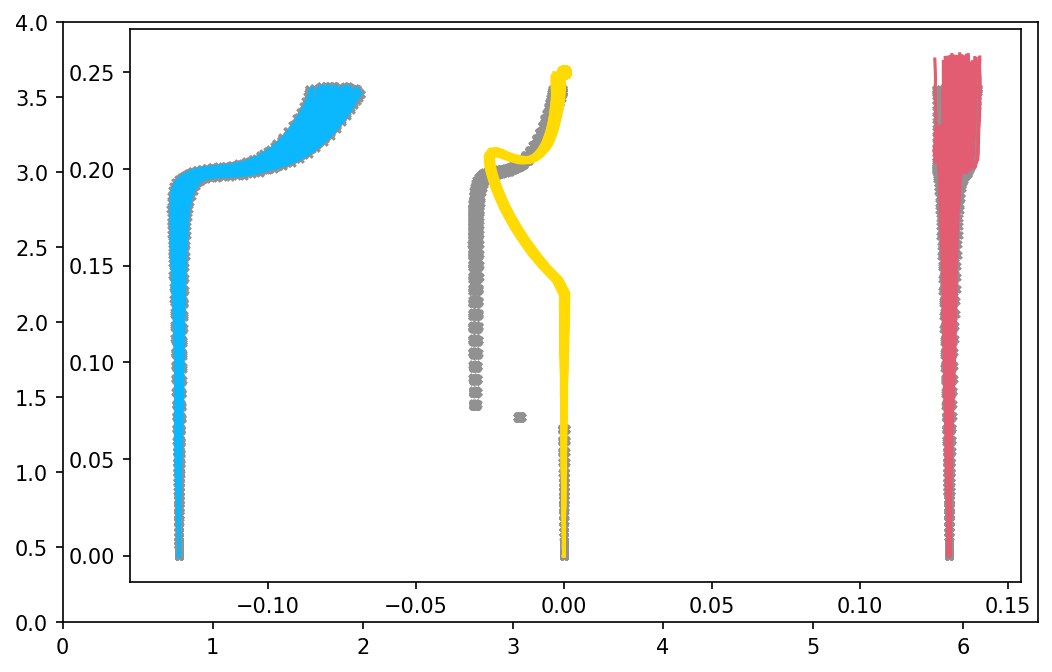

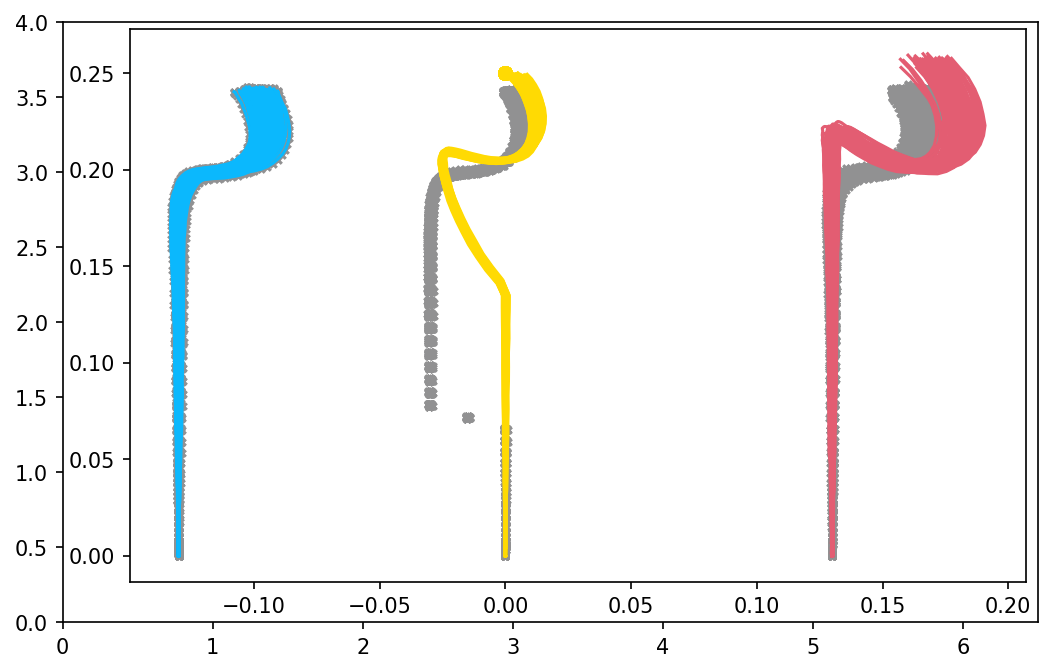

model 2


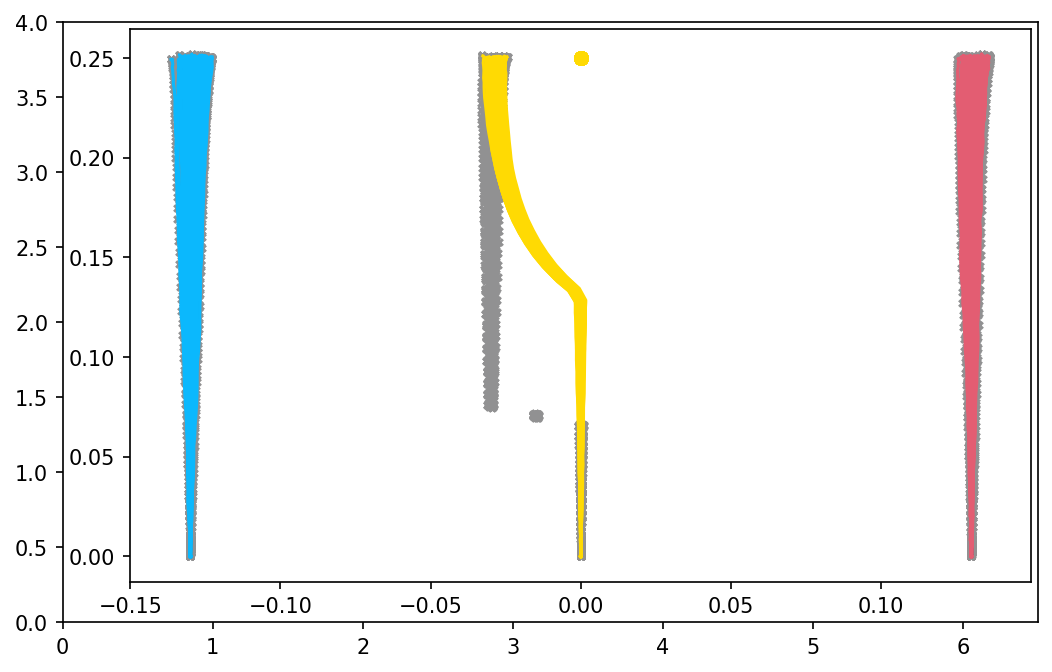

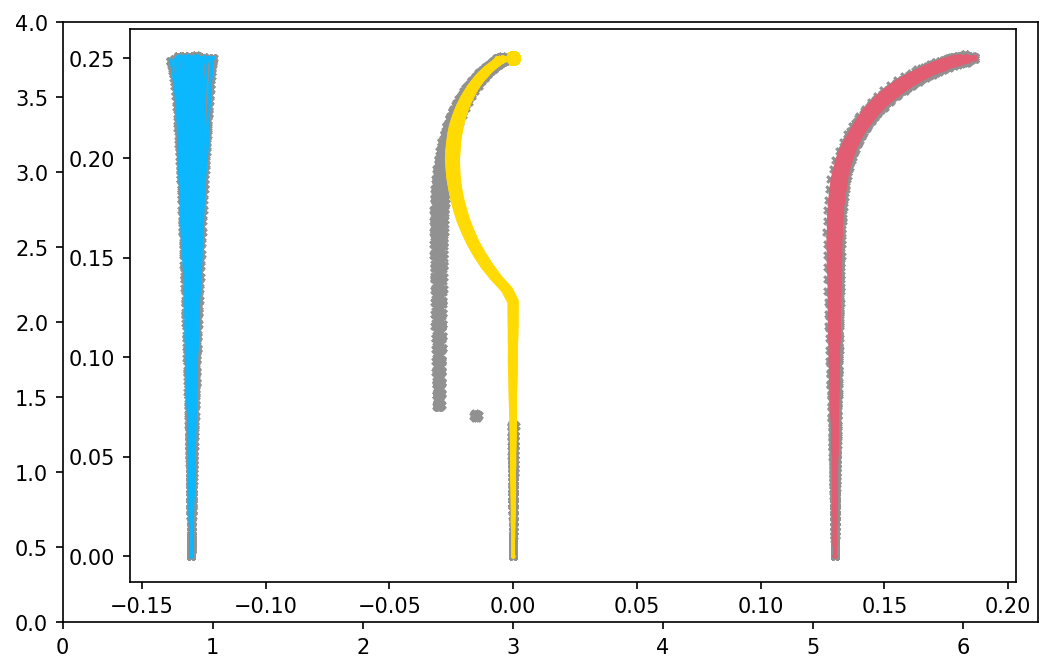

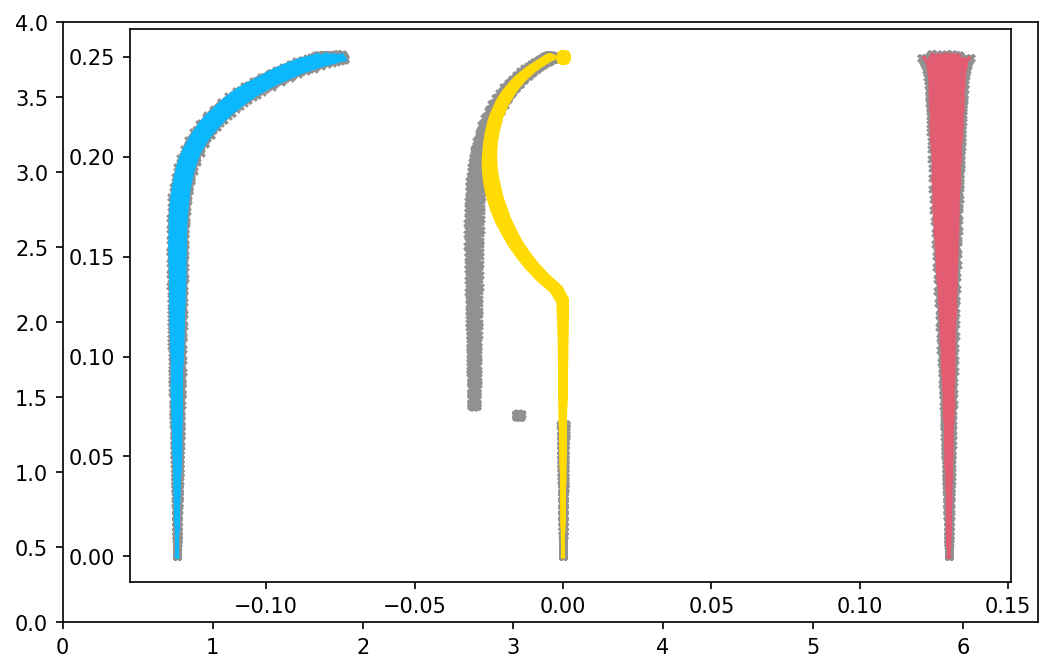

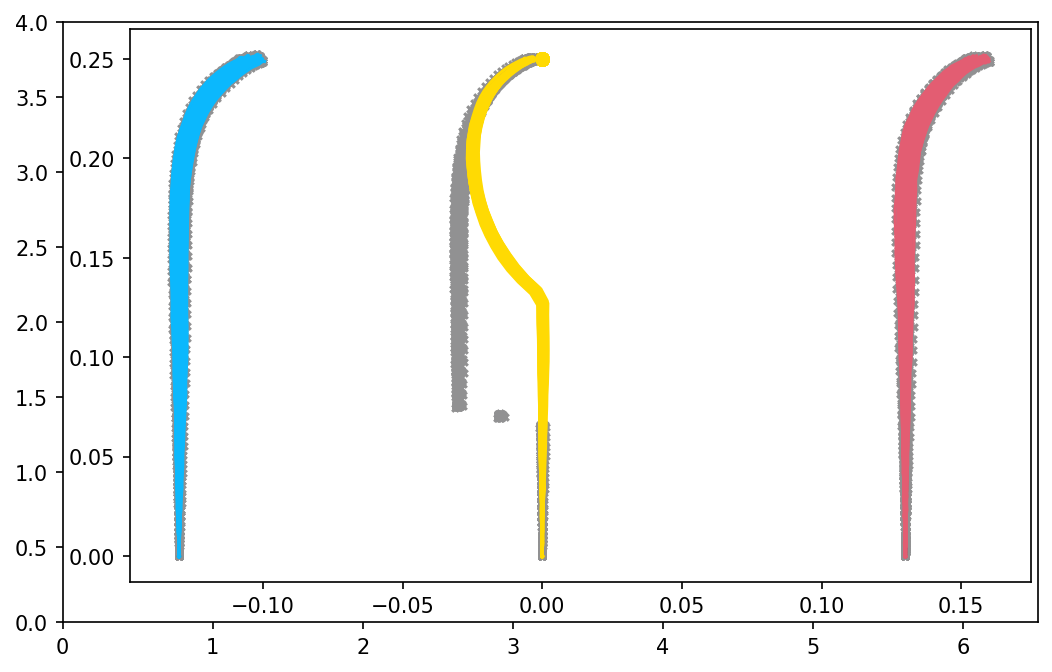

model 3


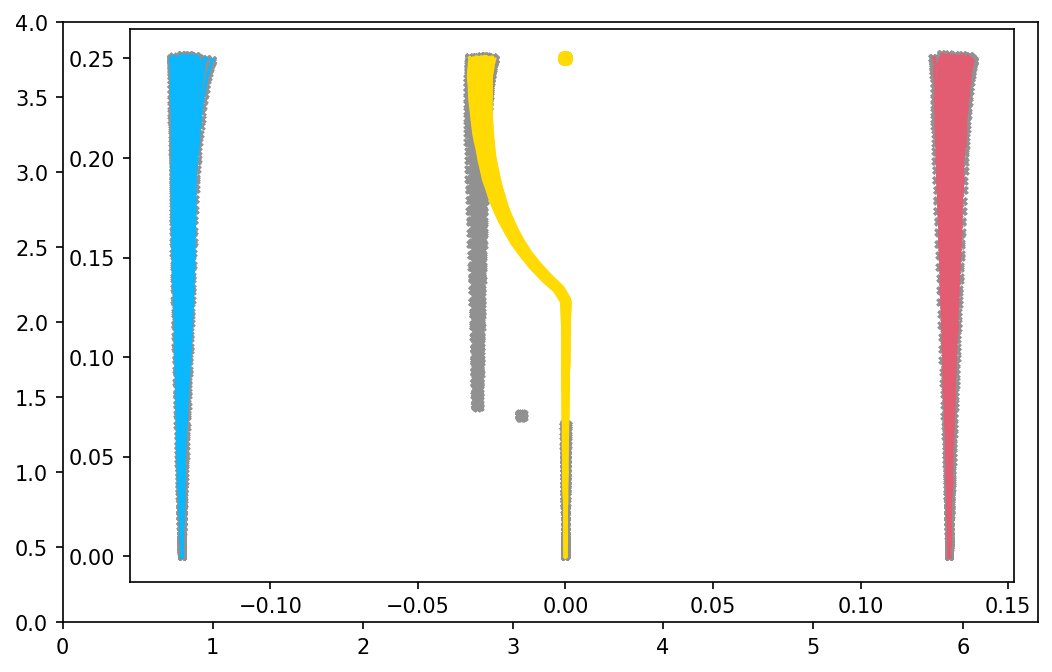

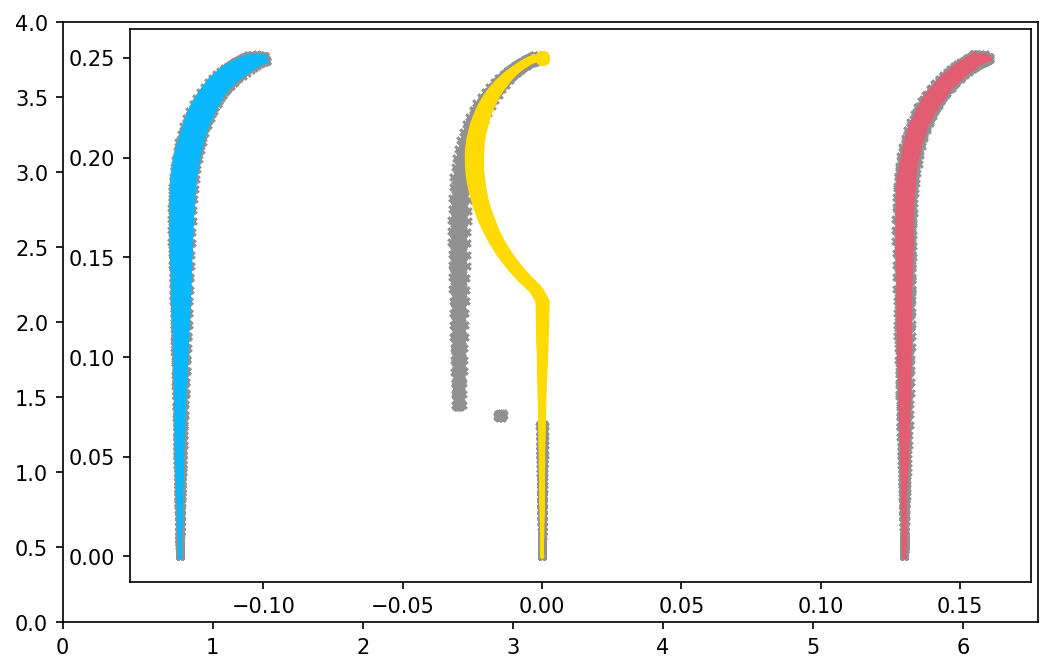

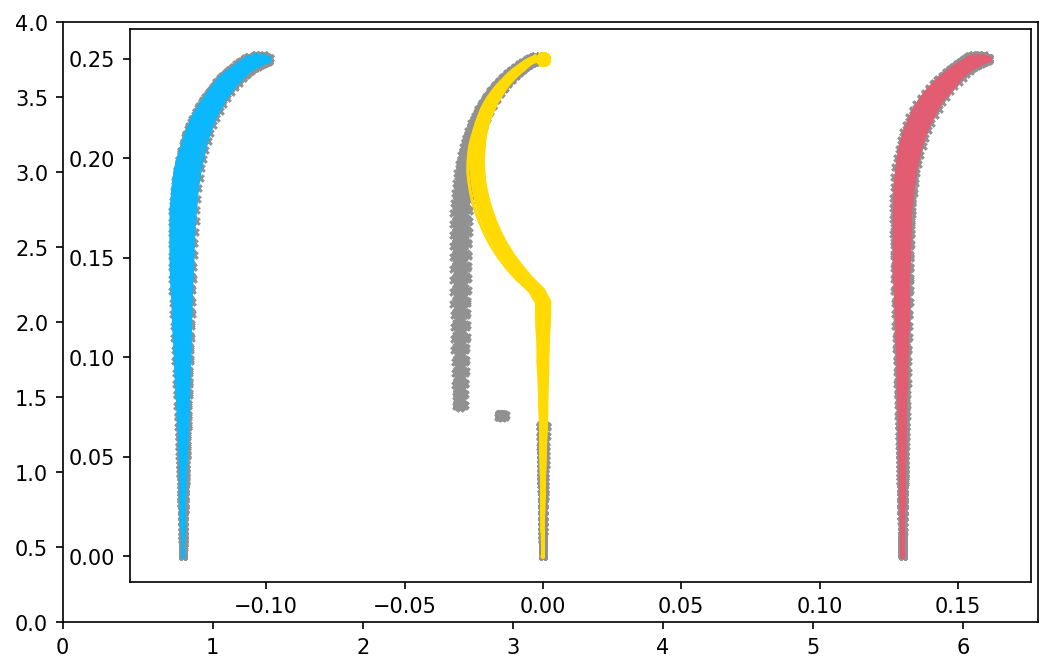

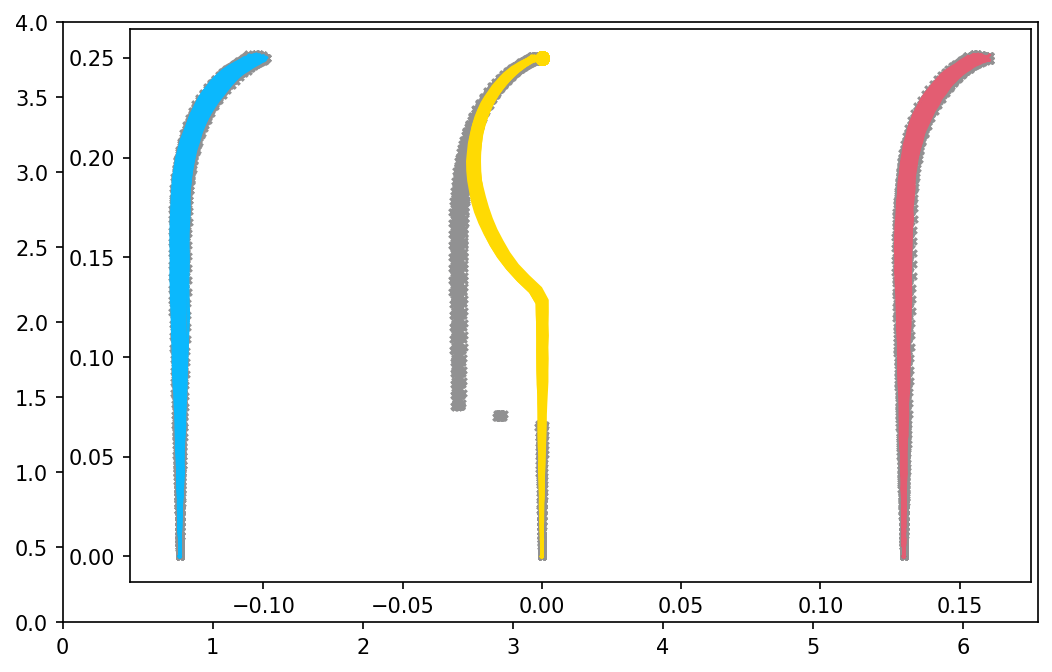

model 4


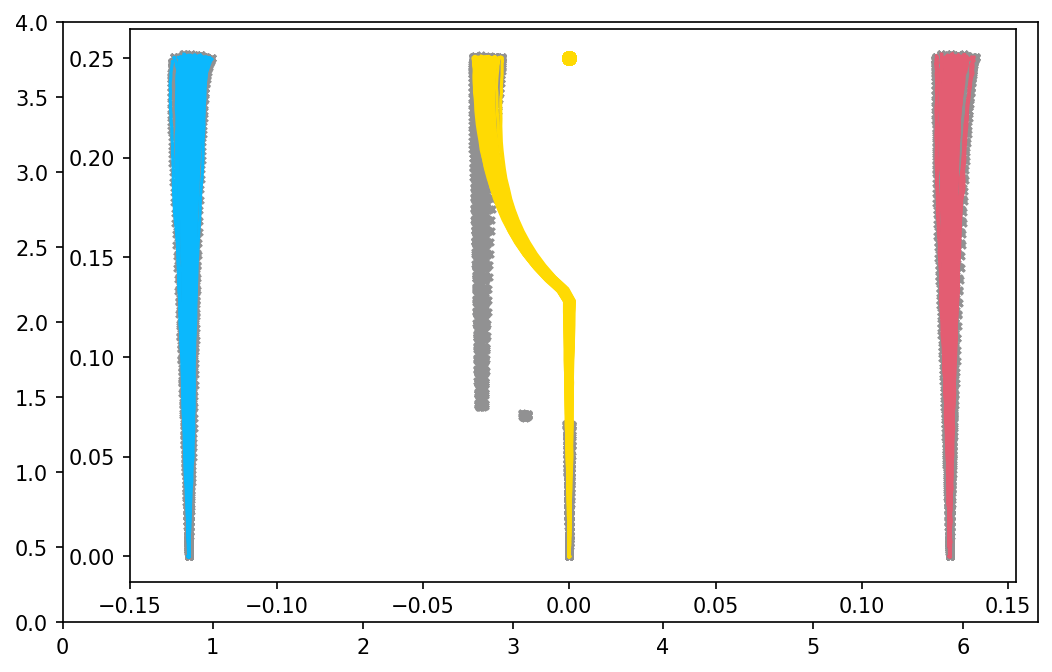

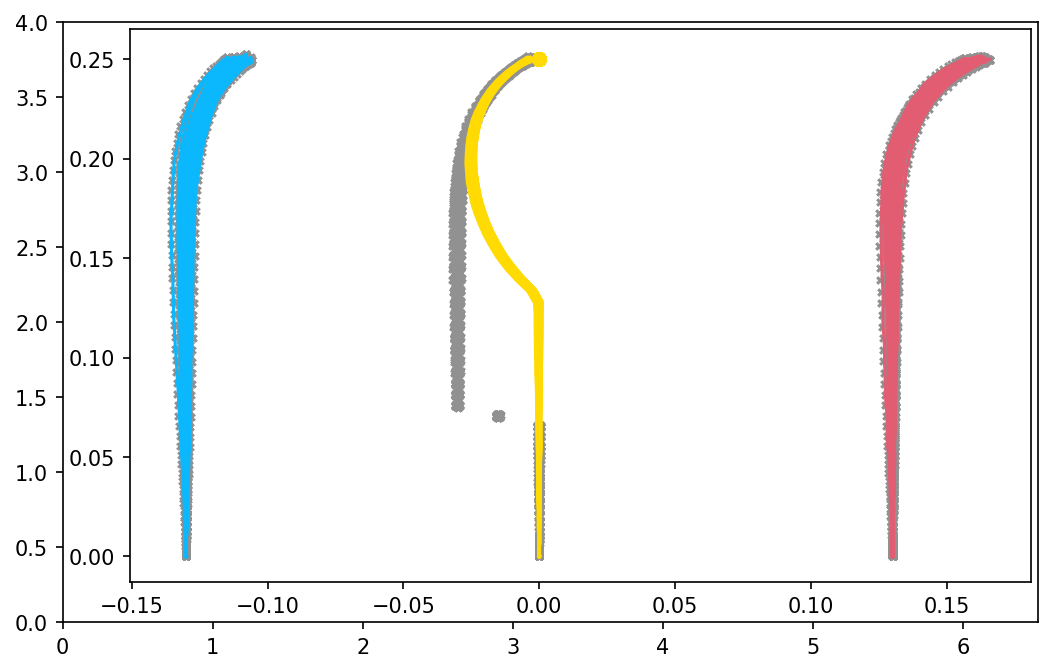

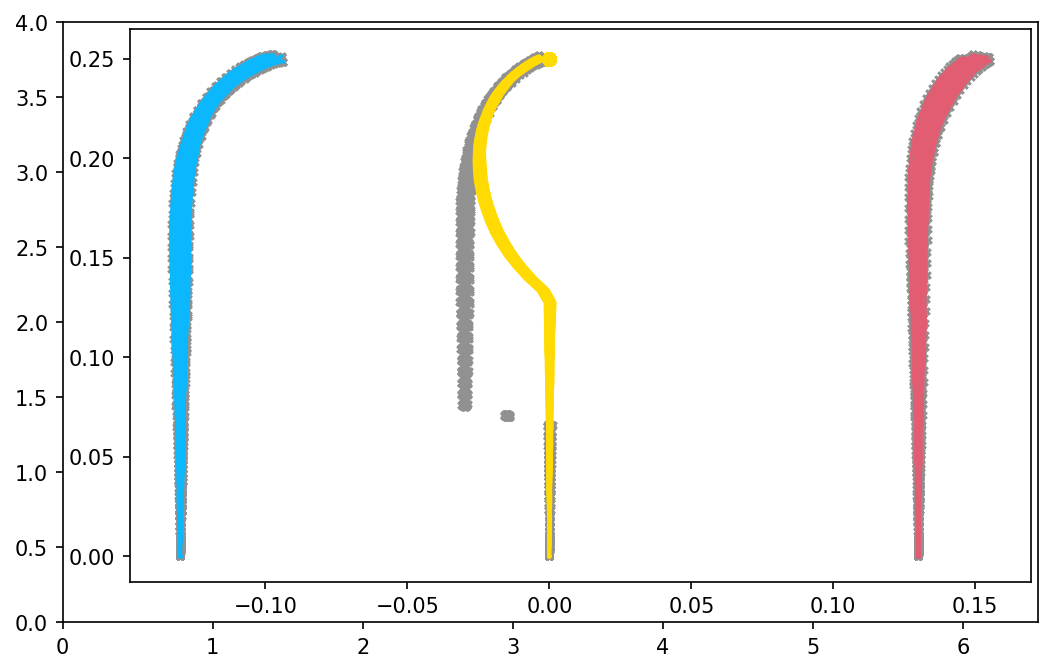

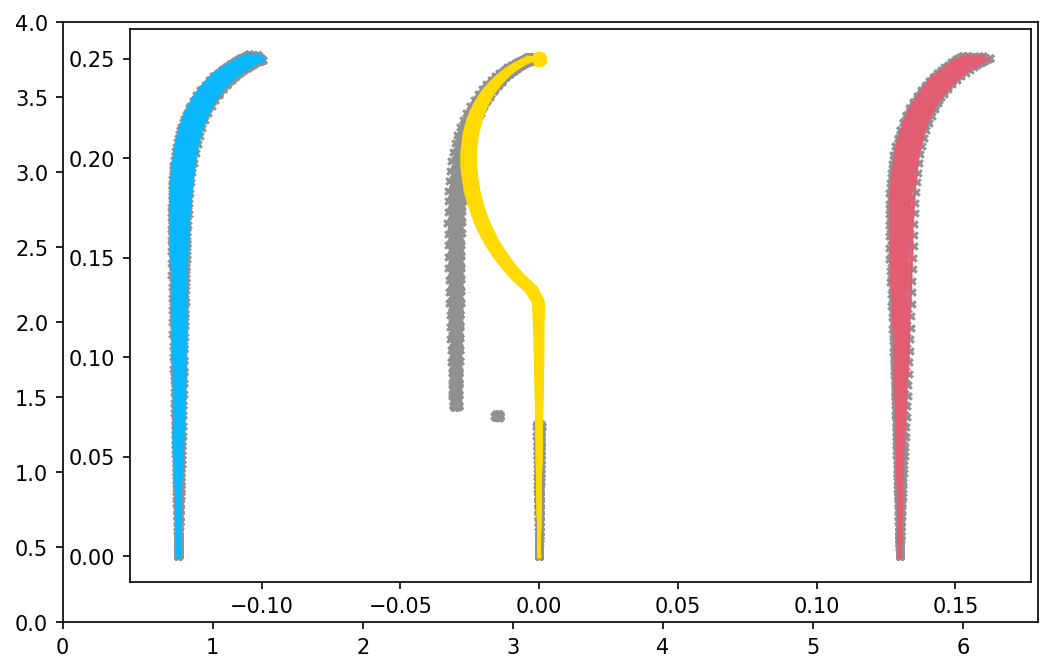

In [19]:
SAVE = False # Don't save model objects unless necessary
ANIMATE = False # Set to true to create animations
NUM_TRIALS = 100 # Set number of trials to run
SAVE_PATH = Path(r"..\..\model_data") # Saves the model objects and animations

# Create dictionaries and lists to store dataframe information
regular_models = {}
probe_models = {}
regular_df_list = []
probe_df_list = []

# Loop through each model
for i in range(len(help_percentages)):
    print(f"model {i+1}")
    c = 0 # experiment trial number counter
    # Loop through conditions (self and partner target widths)
    for j in range(len(Q1_xvals)):
        # Set Qval for P1 and P2 according to experimental condition
        Q1[state_mapping['ccx'],state_mapping['ccx']] = Q1_xvals[j]
        Q1[state_mapping['ccx'],state_mapping['ctx']] = -Q1_xvals[j]
        Q1[state_mapping['ctx'],state_mapping['ccx']] = -Q1_xvals[j]
        Q2[state_mapping['ccx'],state_mapping['ccx']] = Q2_xvals[j]
        Q2[state_mapping['ccx'],state_mapping['ctx']] = -Q2_xvals[j]
        Q2[state_mapping['ctx'],state_mapping['ccx']] = -Q2_xvals[j]
        
        model = GTO.GameTheoryLQG(
            name = const.model_condition_names[j],
            p1_target=param.player_relevancy[j][0],
            p2_target=param.player_relevancy[j][1],
            partner_knowledge=partner_knowledge[i],
            alpha=help_percentages[i],
            x0 = param.x0, # Initial state, 
            A = param.A, 
            B1 = param.B1,
            B2 = param.B2,
            Q1 = Q1,
            Q2 = Q2,
            R11 = R11,
            R22 = R22,
            R12 = R22*help_percentages[i], # P1 caring about P2's energtic cost
            R21 = R11*help_percentages[i], # P2 caring about P1's energtic cost
            C1 = param.C1, 
            C2 = param.C2, 
            sensor_noise_arr1 = param.SENSOR_NOISE_ARR1,
            sensor_noise_arr2 = param.SENSOR_NOISE_ARR2,
            process_noise_value =  param.PROCESS_NOISE,
            internal_model_noise_value=param.INTERNAL_MODEL_NOISE,
            W1_cov = param.W1_cov,
            W2_cov = param.W2_cov,
            V1_cov = param.V1_cov,
            V2_cov = param.V2_cov,
            sensory_delay=param.sensory_delay_steps,
            perturbation=perturbation,
            h=h,
            HIT_TIME=HIT_TIME,
            probe_duration=param.probe_duration_steps,
            perturbation_states=jump_type,
            LQR=False, # Set to True for no noise
            probe_trial=False, # Set's to true below for probe trials
            state_mapping = state_mapping,
        )
        
        # Q vals should be the same for both players in Joint Irrelevant and Joint Relevant conditions
        # for ccx position and on (ccx, ccy, ctx, cty)
        idx = state_mapping['ccx']
        if j==0 or j==3:
            assert np.all(model.MS.Q1[idx:,idx:] == model.MS.Q2[idx:,idx:])
            
        model.add_kalman_filter()
        model.add_feedback_gain()
        
        probe_model = copy.deepcopy(model)
        probe_model.probe_trial = True
        if SAVE:
            with open(SAVE_PATH / f"perturbation_p1_{param.player_relevancy[j][0]}_p2_{param.player_relevancy[j][1]}_"
                                    f"jumptype_{jump_type}_" 
                                    f"perturbation_{perturbation}_"
                                    f"alpha_{help_percentages[i]}_"
                                    f"partnerknowledge_{partner_knowledge[i]}.pkl","wb") as f:
                dill.dump(model,f)
            with open(SAVE_PATH / f"probe_p1_{param.player_relevancy[j][0]}_p2_{param.player_relevancy[j][1]}_"
                                    f"jumptype_{jump_type}_"
                                    f"perturbation_{perturbation}_"
                                    f"alpha_{help_percentages[i]}_"
                                    f"partnerknowledge_{partner_knowledge[i]}.pkl","wb") as f:
                dill.dump(probe_model,f)
                
        #* Create long format data for trials
        for k in range(NUM_TRIALS):
            c+=1
            model.run_simulation()
            model.calculate_cost()
            probe_model.run_simulation()
            probe_model.calculate_cost()
            regular_df = create_single_trial_df(trial=k+1, model=model,
                                    state_mapping=state_mapping, condition=model.name,
                                    p1_target = model.p1_target,
                                    p2_target = model.p2_target, 
                                    experiment_trial_number = c)
            regular_df_list.append(regular_df)
            
            probe_df = create_single_trial_df(trial=k+1, model=probe_model,
                                                state_mapping=state_mapping, condition=probe_model.name,
                                                p1_target = probe_model.p1_target,
                                                p2_target = probe_model.p2_target, 
                                                experiment_trial_number=c)
            probe_df_list.append(probe_df)
        
        regular_models[const.model_condition_names[j]] = copy.deepcopy(model)
        probe_models[const.model_condition_names[j]] = copy.deepcopy(probe_model)
    
    # TODO Fill this out
    if ANIMATE:
        pass

# Stitch dataframes together to create one long format dataframe
regular_df = pl.concat(regular_df_list)
probe_df = pl.concat(probe_df_list)

# Plots

## Trajectories

## Force Production